### Introduction

This Jupyter notebook serves as a computational pipeline to identify candidate kinases for engineering allostery by receiving the results of SCA in .db format, and identifying the sector-connected, negatively-charged residues of each kinase in the processed list and outputting in a format visualizable on pyMOL. For processing the MSA, the sequence OTHER_EIF2AK4_2/590-1001 E2AK4_HUMAN EIF2AK4 Q9P2K8 was used (selected by default using RMSD) and there are 832 sequences after processing. 

### Loading the SCA results

In [74]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import copy
import scipy.cluster.hierarchy as sch
from scipy.stats import scoreatpercentile
import matplotlib.image as mpimg
from IPython.display import display
from IPython.display import Image
from Bio.Seq import Seq
from Bio import motifs
import colorsys
from pysca import scaTools as sca
# import mpld3
import pickle as pickle
from optparse import OptionParser

%matplotlib inline

if not os.path.exists('../output/'):
    os.makedirs('../output/')

In [75]:
db = pickle.load(open('../output/masterAln.db','rb'))
Dseq = db['sequence']  #the results of scaProcessMSA
Dsca = db['sca']       #the results of scaCore
Dsect = db['sector']   #the results of scaSectorID

print("After processing, the alignment size is %i sequences and %i positions" % \
      (Dseq['Nseq'], Dseq['Npos']))
print("With sequence weights, there are %i effective sequences" % (Dseq['effseqs']))

After processing, the alignment size is 574 sequences and 199 positions
With sequence weights, there are 373 effective sequences


### Examine the alignment composition

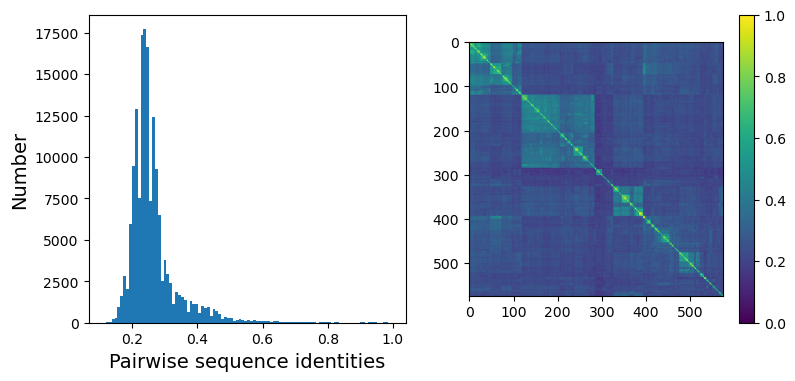

In [76]:
# List all elements above the diagonal (i<j):
listS = [Dsca['simMat'][i,j] for i in range(Dsca['simMat'].shape[0]) \
         for j in range(i+1, Dsca['simMat'].shape[1])]

# Cluster the sequence similarity matrix
Z = sch.linkage(Dsca['simMat'],method = 'complete', metric = 'cityblock')
R = sch.dendrogram(Z,no_plot = True)
ind = R['leaves']

# Plotting
plt.rcParams['figure.figsize'] = 9, 4
plt.subplot(121)
plt.hist(listS, int(round(Dseq['Npos']/2)))
plt.xlabel('Pairwise sequence identities', fontsize=14)
plt.ylabel('Number', fontsize=14)
plt.subplot(122)
plt.imshow(Dsca['simMat'][np.ix_(ind,ind)], vmin=0, vmax=1); plt.colorbar();

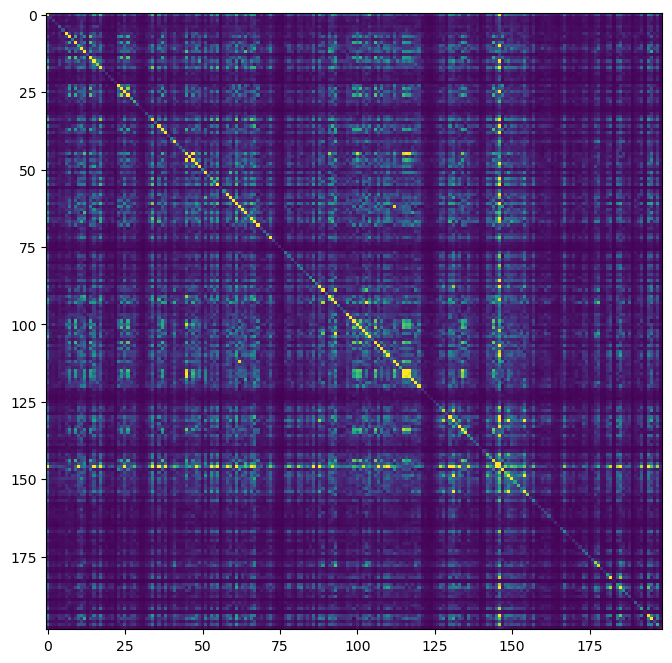

In [77]:
plt.rcParams['figure.figsize'] = 13, 8
plt.imshow(Dsca['Csca'], vmin=0, vmax=1.4,interpolation='none',\
           aspect='equal')

Number of eigenmodes to keep is 4


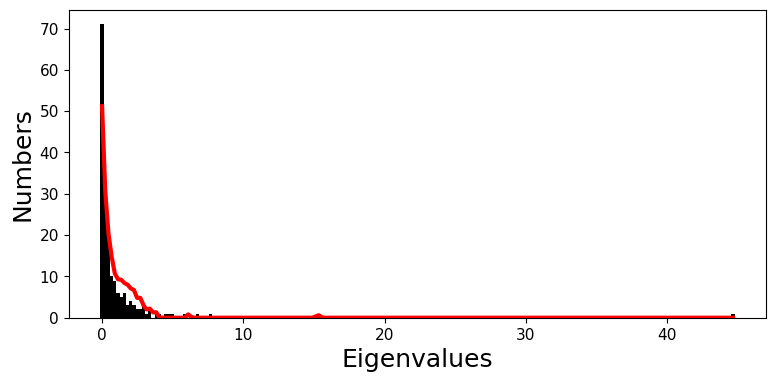

In [78]:
plt.rcParams['figure.figsize'] = 9, 4
hist0, bins = np.histogram(Dsca['Lrand'].flatten(), bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
hist1, bins = np.histogram(Dsect['Lsca'], bins=Dseq['Npos'], \
                           range=(0,Dsect['Lsca'].max()))
plt.bar(bins[:-1], hist1, np.diff(bins),color='k')
plt.plot(bins[:-1], hist0/Dsca['Ntrials'], 'r', linewidth=3)
plt.tick_params(labelsize=11)
plt.xlabel('Eigenvalues', fontsize=18); plt.ylabel('Numbers', fontsize=18);
print('Number of eigenmodes to keep is %i' %(Dsect['kpos']))
#mpld3.display()

IC 1 is composed of 19 positions:
7+18+24+35+50+52+72+79+82+87+88+118+124+139+173+193+282+285+294

IC 2 is composed of 27 positions:
14+16+19+21+33+34+36+53+62+64+66+83+89+123+131+132+133+138+140+148+151+152+153+177+178+191+194

IC 3 is composed of 12 positions:
57+121+125+129+134+135+136+141+155+277+278+286

IC 4 is composed of 14 positions:
22+68+70+80+85+120+154+171+174+189+195+196+201+295



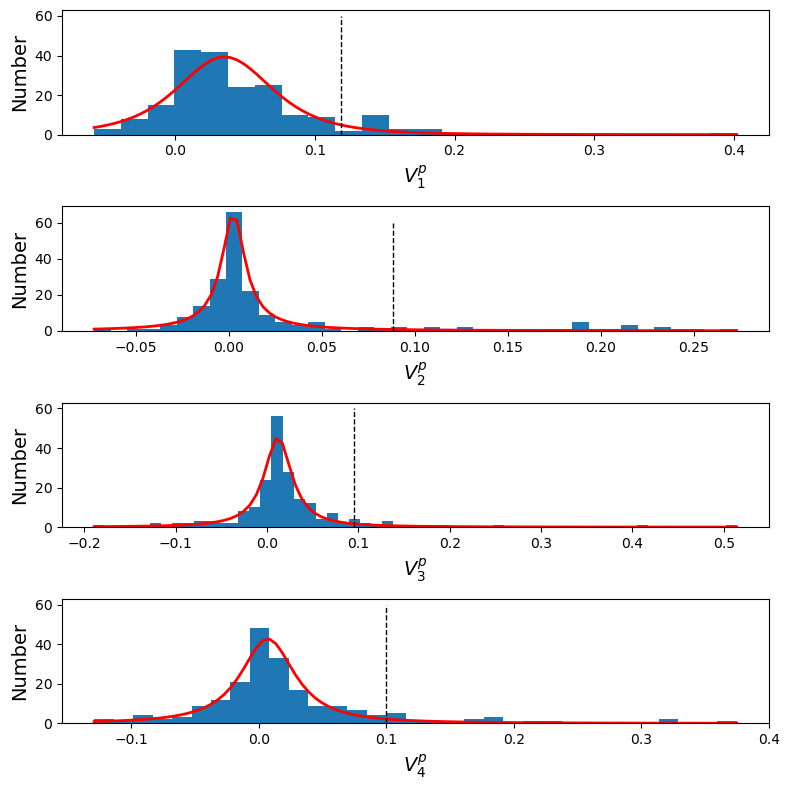

In [79]:
plt.rcParams['figure.figsize'] = 8, 8

Vpica = Dsect['Vpica']
for k in range(Dsect['kpos']):
    iqr = scoreatpercentile(Vpica[:,k],75) - scoreatpercentile(Vpica[:,k],25)
    binwidth=2*iqr*(len(Vpica)**(-0.33))
    nbins=int(round((max(Vpica[:,k])-min(Vpica[:,k]))/binwidth))
    plt.subplot(Dsect['kpos'],1,k+1)
    h_params = plt.hist(Vpica[:,k], nbins)
    x_dist = np.linspace(min(h_params[1]), max(h_params[1]), num=100)
    plt.plot(x_dist,Dsect['scaled_pd'][k],'r',linewidth = 2)
    plt.plot([Dsect['cutoff'][k],Dsect['cutoff'][k]], [0,60], 'k--',linewidth = 1)
    plt.xlabel(r'$V^p_{%i}$'%(k+1), fontsize=14)
    plt.ylabel('Number', fontsize=14)
plt.tight_layout()

for n,ipos in enumerate(Dsect['ics']):
    sort_ipos = sorted(ipos.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('IC %i is composed of %i positions:' % (n+1,len(ats_ipos)))
    print(ic_pymol + "\n")

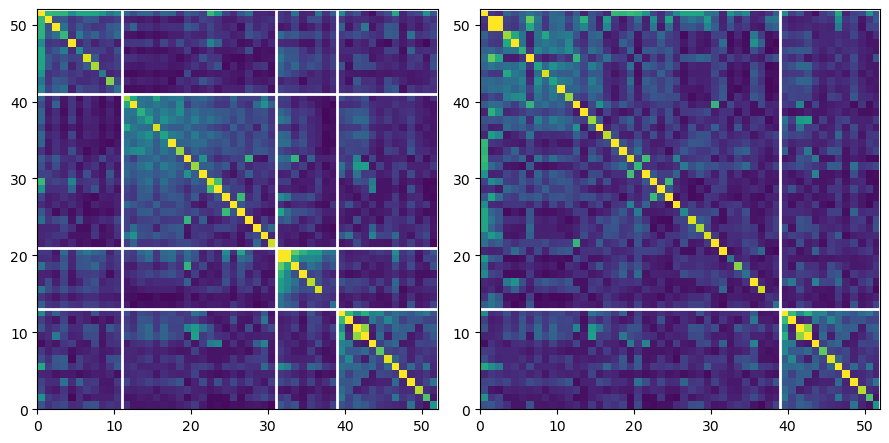

In [73]:
#plot the SCA positional correlation matrix, ordered by contribution to the top ICs
plt.rcParams['figure.figsize'] = 9, 9
plt.subplot(121)
plt.imshow(Dsca['Csca'][np.ix_(Dsect['sortedpos'], Dsect['sortedpos'])], \
           vmin=0, vmax=2.2,interpolation='none',\
           aspect='equal',extent=[0,sum(Dsect['icsize']),\
                                  0,sum(Dsect['icsize'])])
line_index=0
for i in range(Dsect['kpos']):
    plt.plot([line_index+Dsect['icsize'][i],line_index+Dsect['icsize'][i]],\
             [0,sum(Dsect['icsize'])],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[sum(Dsect['icsize'])-\
            line_index,sum(Dsect['icsize'])-line_index],'w', linewidth = 2)
    line_index += Dsect['icsize'][i]

#define the new sector groupings - 3 total
sec_groups = ([0,1,2],[3])
sectors = list()
c = [0.66, 0]
for n,k in enumerate(sec_groups):
    s = sca.Unit()
    all_items = list()
    all_Vp = list()
    for i in k:
        all_items = all_items+Dsect['ics'][i].items
        all_Vp = all_Vp+list(Dsect['ics'][i].vect)
    svals = np.argsort(all_Vp)
    s.items = [all_items[i] for i in svals]
    s.col = c[n]
    sectors.append(s)

#plot the re-ordered matrix
plt.subplot(122)
line_index=0
sortpos = list()
for s in sectors:
    sortpos.extend(s.items)
plt.imshow(Dsca['Csca'][np.ix_(sortpos, sortpos)], vmin=0, vmax=2.2,\
           interpolation='none',aspect='equal',\
           extent=[0,len(sortpos),0,len(sortpos)])
for s in sectors:
    plt.plot([line_index+len(s.items),line_index+len(s.items)],\
             [0,len(sortpos)],'w', linewidth = 2)
    plt.plot([0,sum(Dsect['icsize'])],[len(sortpos)-line_index,\
                    len(sortpos)-line_index],'w', linewidth = 2)
    line_index += len(s.items)
plt.tight_layout()

In [80]:
for i,k in enumerate(sectors):
    sort_ipos = sorted(k.items)
    ats_ipos = ([Dseq['ats'][s] for s in sort_ipos])
    ic_pymol = ('+'.join(ats_ipos))
    print('Sector %i is composed of %i positions:' % (i+1,len(ats_ipos)))
    print(ic_pymol + "\n")
sca.writePymol('5P21', sectors, Dsect['ics'], Dseq['ats'], \
               '../output/PF00071.pml','A', '../Inputs/', 0)

Sector 1 is composed of 39 positions:
14+16+18+19+21+34+35+37+64+65+66+70+72+78+81+82+109+112+120+121+124+126+128+134+137+138+141+142+147+151+153+155+156+158+169+171+178+188+197

Sector 2 is composed of 13 positions:
7+54+110+113+114+118+119+123+130+139+170+189+196

